In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import sys

from tqdm import tqdm
import matplotlib

In [4]:
config_file = "config_kdv.json"

with open(config_file, "r") as f:
    config = json.load(f)["sin"]

In [5]:
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]


n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']

# forcing_type = "linear"


# n_psi_train = config["nn_settings"]["n_psi_train"]
n_psi_train = 2
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2024-03-29 11:30:32.082872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 11:30:32.186338: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 11:30:32.691952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-03-29 11:30:32.692134: W tensorflow/compiler/xla/stre

In [7]:
from koopmanlib.functions import *

In [8]:
from koopmanlib.target import KortewegDeVriesTarget

In [9]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01

In [10]:
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)

In [11]:
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3

In [12]:
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

In [13]:
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)


data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

# Build model

## PK-NN

In [14]:
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

model_pk.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

checkpoint_path = os.path.join(weights_path, "n_trainable_psi_2_pk_kdv_weights_" + forcing_type + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        save_freq="epoch",
    )


from tqdm.keras import TqdmCallback
# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

callbacks = [lr_callback, checkpoint_callback, tqdm_callback]


2024-03-29 11:30:36.205208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-29 11:30:36.205269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-03-29 11:30:36.205278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-03-29 11:30:36.205473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-03-29 11:30:36.205506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-03-29 11:30:36.205513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-03-29 11:30:36.206346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [15]:

history_pk = model_pk.fit(
    x=[data_x, data_y, data_u],
    y=zeros_data_y_train,
    validation_split=0.2,
        epochs=500,
        batch_size=200,
        callbacks=callbacks,
        verbose=0
    )


In [16]:

# model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

In [17]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)

    psi_y = dic_pk(y0)
    obs_list = [psi_y @ B_obs]

    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

# Testing problems

In [18]:
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "steelblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"

## Prediction

In [19]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [20]:
pred_traj_number = 1
np.random.seed(521)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 1
traj_len_pred = int(Tsim_pred / T)

for seed_IC, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv.generate_y0(seed_IC)

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = (
        np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    )

    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)

In [21]:
param_pred.shape

(100, 3)

In [22]:
t_list = np.linspace(0,1,traj_len_pred)
t_list

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [23]:
def generate_param(t_list):
    u1 = np.sin(4 * t_list)
    u2 = np.cos(5 * t_list)
    u3 = np.sin(6 * t_list)
    return np.stack([u1, u2, u3], axis=-1)

In [24]:
# def generate_param(t_list):
#     u1 = np.sin(t_list)
#     u2 = np.sin(t_list)
#     u3 = np.sin(t_list)
#     return np.stack([u1, u2, u3], axis=-1)

In [25]:
param_sin = generate_param(t_list)
param_sin.shape

(100, 3)

In [26]:
# param_sin = generate_param(t_list)
# param_sin = np.zeros(shape=(param_sin.shape))

In [27]:
# param = tf.reshape(param_pred, shape=(param_pred.shape[0], 1, param_dim))
param = tf.reshape(param_sin, shape=(param_sin.shape[0], 1, param_dim))

y0 = y0_pred.reshape(1, -1)

psi_y = dic_pk(y0)
# obs_list = [psi_y @ B_obs]

pk_psi_y_list = [psi_y]

tau = param.shape[0]

for i in range(tau):
    psi_y = model_K_u_pred_pk([param[i], psi_y])
    pk_psi_y_list.append(psi_y)


In [28]:
pk_psi_y_list = np.asarray(pk_psi_y_list)

In [29]:
# # Compute bilinear model soln

# psi_y = solver_bilinear.dic.call(y0)
# bilinear_psi_y_list = [psi_y]

# for u in param:
#     u_psiy = tf.einsum("ij,ik->kij", psi_y, u)
#     u_psiy_list = []
#     for curr in u_psiy:
#         u_psiy_list.append(curr)
#     u_psiy_list = tf.concat(u_psiy_list, axis=-1)

#     psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
#         psi_y
#     ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)

#     bilinear_psi_y_list.append(psi_y)

# bilinear_psi_y_list = np.asarray(bilinear_psi_y_list)

IndexError: index 5 is out of bounds for axis 2 with size 5

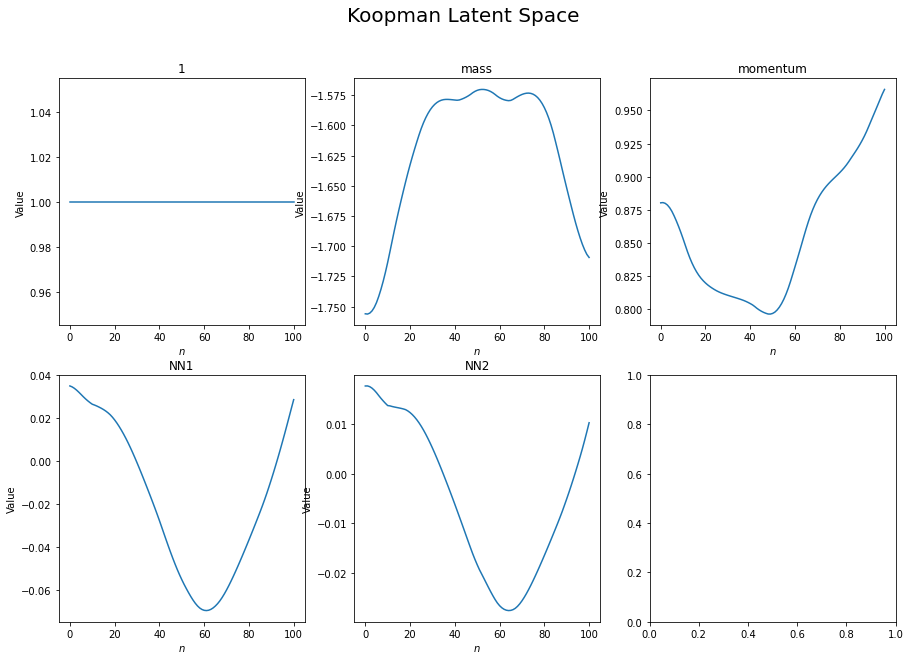

In [30]:
# Time steps from 0 to 10
time_steps = np.arange(0, traj_len_pred+1)

# Custom titles for each subplot
custom_titles = [
    "1",
    "mass",
    "momentum",
    "NN1",
    "NN2",
    "NN3"
]
with matplotlib.rc_context({'font.size': 15}):
    # Plotting
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns of subfigures
    fig.suptitle('Koopman Latent Space', fontsize=20)
    for i in range(6):
        # Select the appropriate subplot
        ax = axs[i // 3, i % 3]
        # Plot the i-th component of the vector against time steps
        ax.plot(time_steps, pk_psi_y_list[:, 0, i])
        # Set custom title for each subplot
        ax.set_title(custom_titles[i])
        ax.set_xlabel(r'$n$')
        ax.set_ylabel('Value')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    

# plt.savefig(os.path.join(figures_path, 'kdv_latent_each_componet.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_latent_each_componet.pdf'), dpi=200, bbox_inches='tight')



In [ ]:
param = tf.reshape(param_sin, shape=(param_sin.shape[0], 1, param_dim))


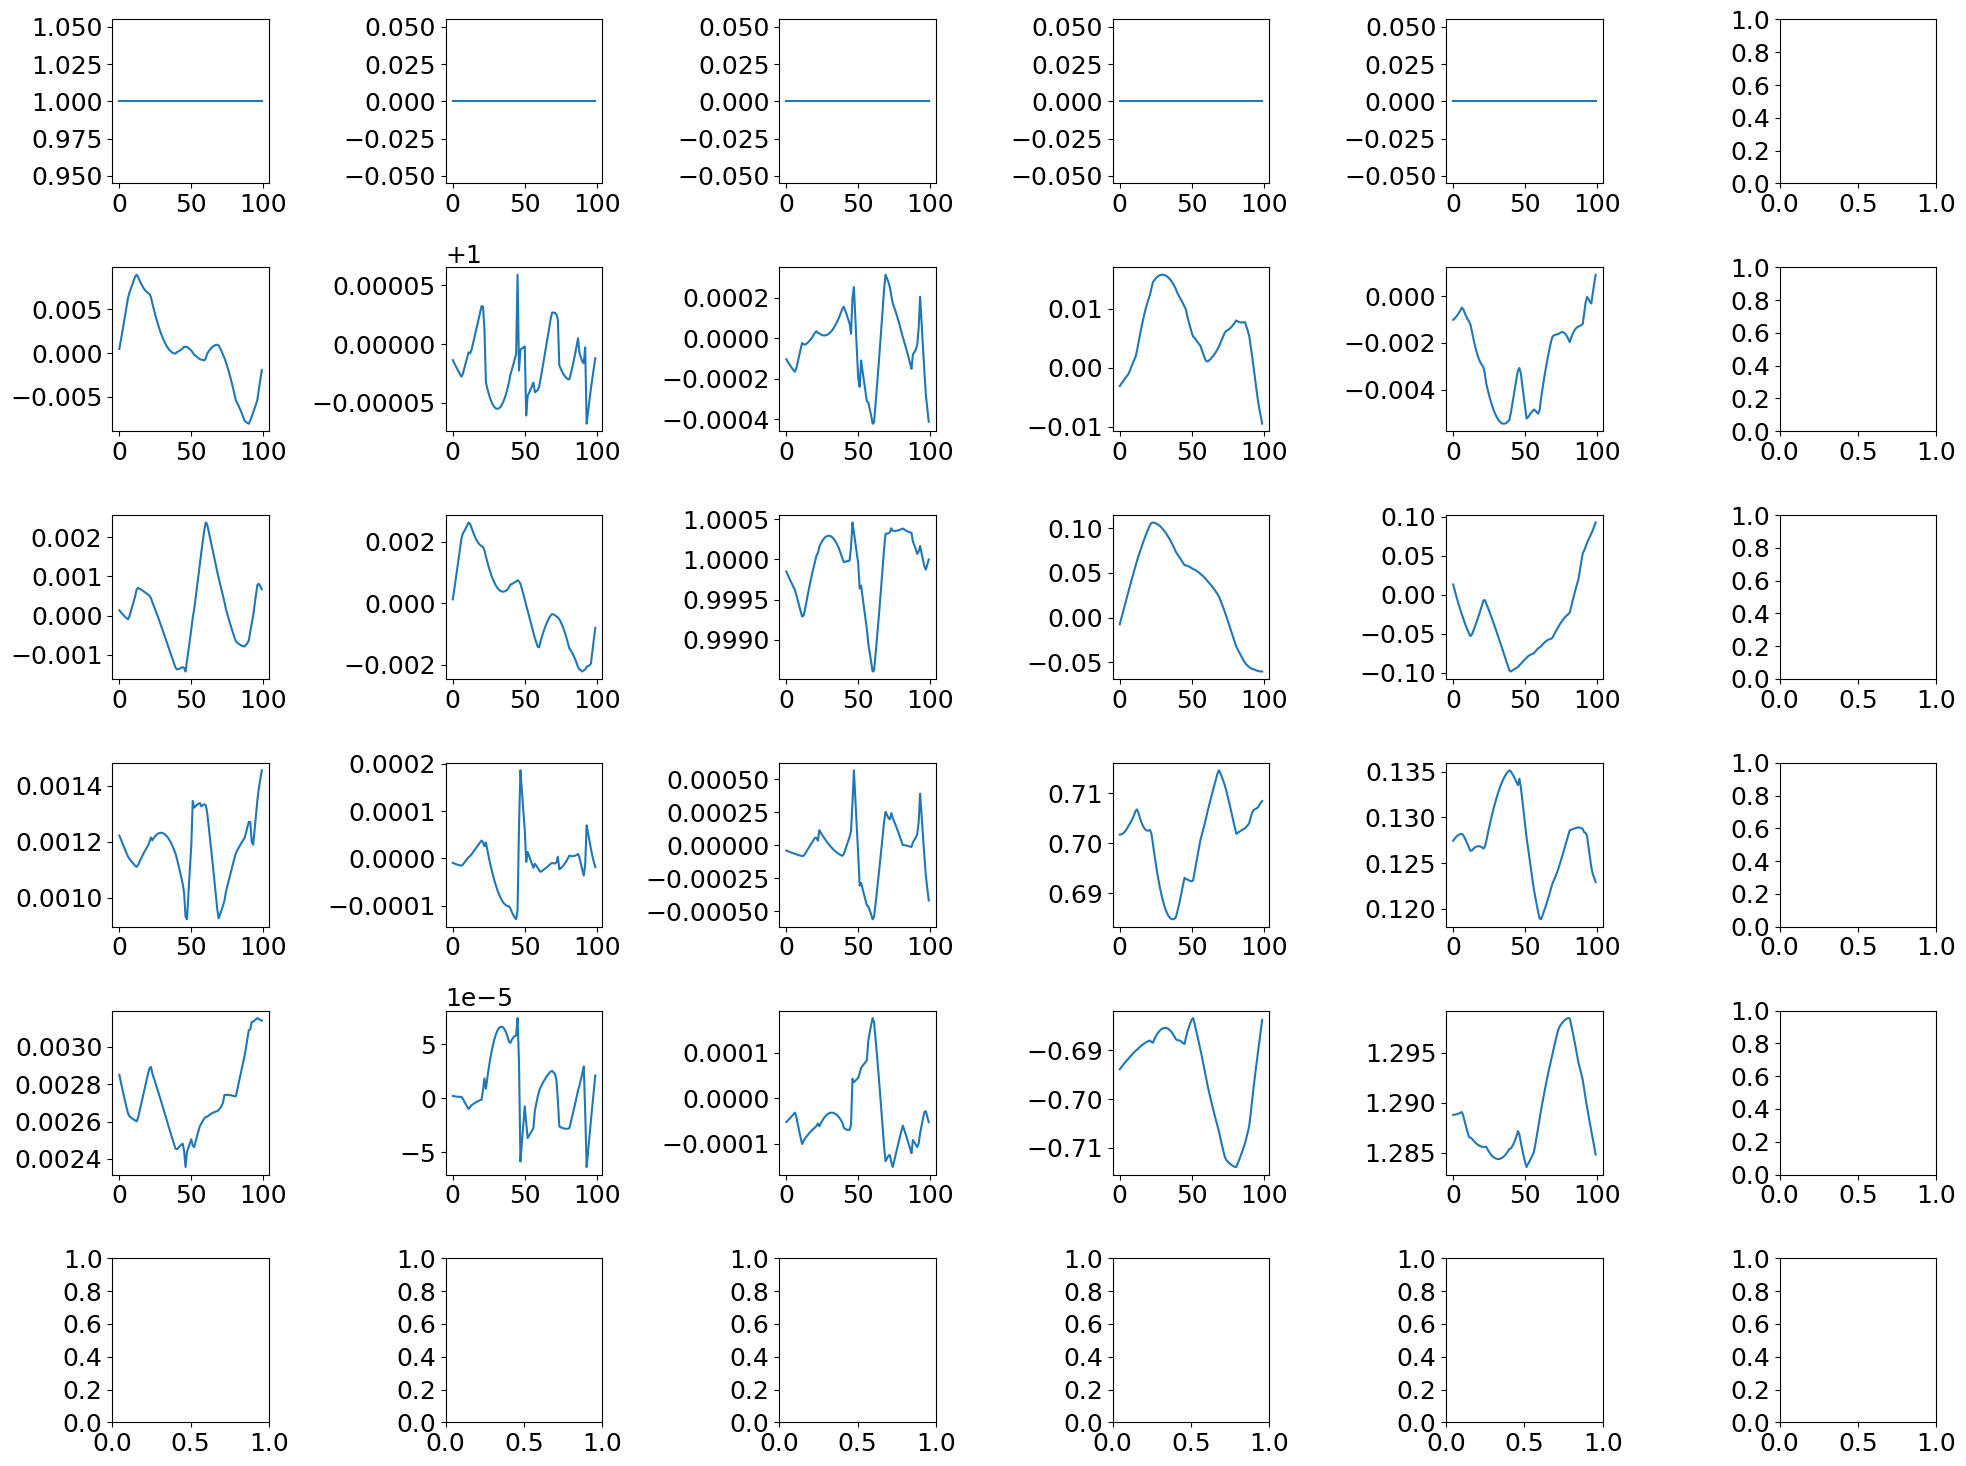

In [ ]:
with matplotlib.rc_context({'font.size': 18}):
    fig, axs = plt.subplots(6, 6, figsize=(20, 15)) 

    for i in range(5):
        for j in range(5):
            axs[i, j].plot(model_K_u(param)[:, j, i])  
            # axs[i, j].set_title(f"({i+1},{j+1})")

    plt.tight_layout()

    # plt.savefig(os.path.join(figures_path, 'kdv_latent_each_K.png'), dpi=200, bbox_inches='tight')
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_each_K.pdf'), dpi=200, bbox_inches='tight')



In [ ]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [ ]:
kdv_soln = compute_kdv_soln(y0_pred, param_sin)
kdv_soln = np.asarray(kdv_soln)

In [ ]:
kdv_soln.shape

(101, 128)

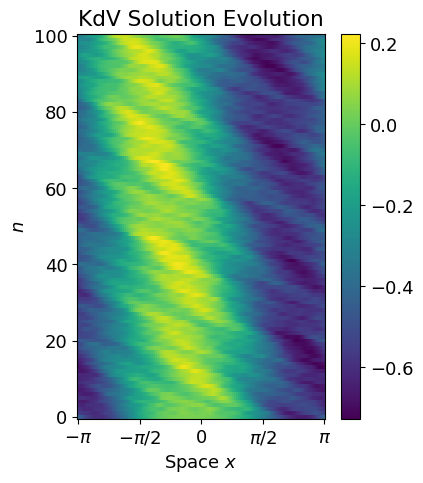

In [ ]:
with matplotlib.rc_context({'font.size': 13}):
    # Create a meshgrid for the spatial and temporal dimensions
    # Spatial dimension: from -π to π
    x = np.linspace(-np.pi, np.pi, 128)
    # Temporal dimension: 11 time points
    y = np.arange(traj_len_pred+1)
    X, Y = np.meshgrid(x, y)

    # Plotting
    fig, ax = plt.subplots(figsize=(4,5))
    # Display the data using pcolormesh
    c = ax.pcolormesh(X, Y, kdv_soln, shading='auto', cmap='viridis')  # cmap can be adjusted to your preference

    # Set the title and labels
    ax.set_title('KdV Solution Evolution')
    ax.set_xlabel(r'Space $x$')
    ax.set_ylabel(r'$n$')

    # Set x-ticks to show π, 0, and -π
    ax.set_xticks([-np.pi, -np.pi/2, 0,np.pi/2, np.pi])
    ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

    # Adding a colorbar for interpretation
    fig.colorbar(c, ax=ax)

    # plt.savefig(os.path.join(figures_path, 'kdv_latent_soln.png'), dpi=200, bbox_inches='tight')
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_soln.pdf'), dpi=200, bbox_inches='tight')

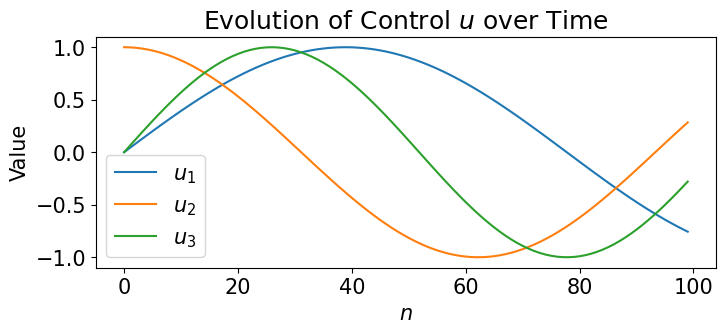

In [ ]:
# Time points
time_points = np.arange(param.shape[0])
with matplotlib.rc_context({'font.size': 15}):
    # Plotting
    plt.figure(figsize=(8, 3))

    # Plot each component
    for i in range(3):
        plt.plot(time_points, param_sin[:, i], label=r'$u_{{{}}}$'.format(i+1))

    # Adding legend
    plt.legend()

    # Adding titles and labels
    plt.title(r'Evolution of Control $u$ over Time')
    plt.xlabel(r'$n$')
    plt.ylabel('Value')
    
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_control.png'), dpi=200, bbox_inches='tight')
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_control.pdf'), dpi=200, bbox_inches='tight')


In [ ]:
kdv_mass_pred = dx * tf.reshape(
                tf.math.reduce_sum(kdv_soln, axis=-1), shape=(-1, 1)
            )
kdv_momentum_pred = dx * tf.reshape(
                tf.math.reduce_sum(tf.square(kdv_soln), axis=-1), shape=(-1, 1)
            )

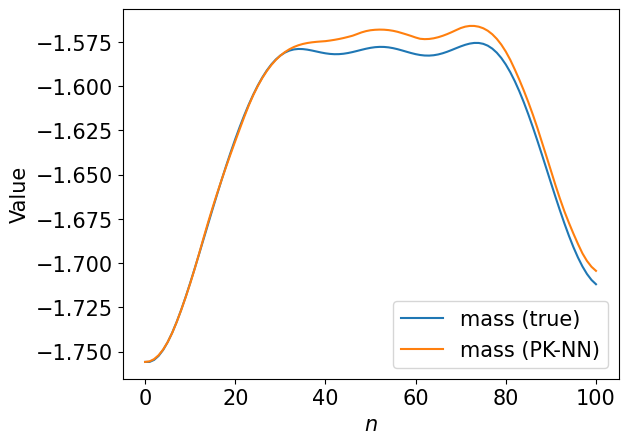

In [ ]:
with matplotlib.rc_context({'font.size': 15}):
    plt.plot(kdv_mass_pred, label='mass (true)')
    plt.plot(pk_psi_y_list[:, 0, 1], label='mass (PK-NN)')
    # plt.plot(bilinear_psi_y_list[:, 0, 1], label='mass (bilinear)')
    plt.xlabel(r'$n$')
    plt.ylabel('Value')
    plt.legend()

    # plt.savefig(os.path.join(figures_path, 'kdv_latent_mass.png'), dpi=200, bbox_inches='tight')
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_mass.pdf'), dpi=200, bbox_inches='tight')


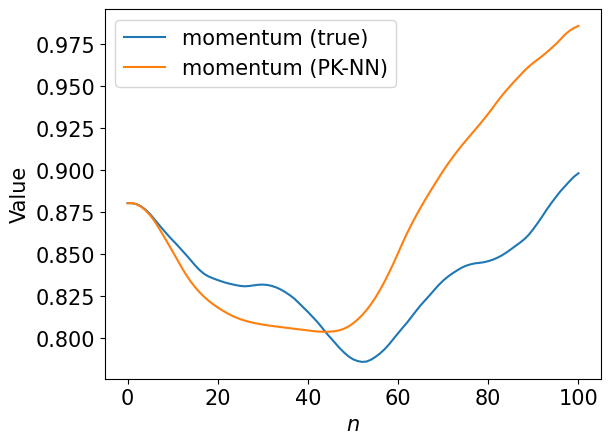

In [ ]:
with matplotlib.rc_context({'font.size': 15}):
    plt.plot(kdv_momentum_pred, label='momentum (true)')
    plt.plot(pk_psi_y_list[:, 0, 2], label='momentum (PK-NN)')
    # plt.plot(bilinear_psi_y_list[:, 0, 2], label='momentum (bilinear)')
    plt.xlabel(r'$n$')
    plt.ylabel('Value')
    plt.legend()
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_momentum.png'), dpi=200, bbox_inches='tight')
    # plt.savefig(os.path.join(figures_path, 'kdv_latent_momentum.pdf'), dpi=200, bbox_inches='tight')


In [439]:
tf.reduce_mean(tf.square(kdv_momentum_pred[:,0] - pk_psi_y_list[:, 0, 2]))

<tf.Tensor: shape=(), dtype=float64, numpy=2.264745237987692e-05>

In [440]:
tf.reduce_mean(tf.square(kdv_momentum_pred[:,0] - bilinear_psi_y_list[:, 0, 2]))


<tf.Tensor: shape=(), dtype=float64, numpy=0.0003607458016029343>

In [441]:
tf.reduce_mean(tf.square(kdv_mass_pred[:,0] - pk_psi_y_list[:, 0, 1]))


<tf.Tensor: shape=(), dtype=float64, numpy=1.5645483107173796e-05>

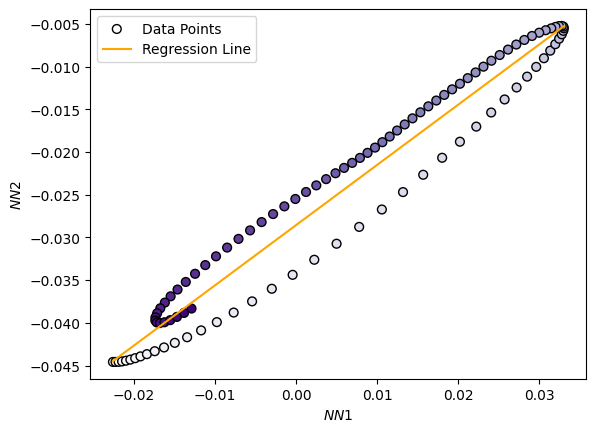

In [488]:
NN1 = pk_psi_y_list[:, 0, 3]
NN2 = pk_psi_y_list[:, 0, 4]

# Compute the linear regression (slope and intercept)
slope, intercept = np.polyfit(NN1, NN2, 1)

# Create the best-fit line
x = np.linspace(NN1.min(), NN1.max(), 100)
y = slope * x + intercept

# Plotting the original data and the regression line
plt.scatter(NN1, NN2, c=range(len(NN1)), cmap='Purples', label='Data Points', s=40, edgecolor='black', linewidth=1, marker='o')
plt.plot(x, y, color='orange', label='Regression Line')
plt.xlabel(r'$NN1$')
plt.ylabel(r'$NN2$')
# plt.title('Linear Regression between NN1 and NN2')
plt.legend()
# plt.savefig(os.path.join(figures_path, 'kdv_latent_NN1NN2.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_latent_NN1NN2.pdf'), dpi=200, bbox_inches='tight')

plt.show()